# Install and import packages

In [3]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState
import os
import pandas as pd
import torch

from training_JUND import get_dataloader, Objective_MLP, validate_epoch

# Training model and tune hyperparameters

In [2]:
load_dotenv()

DATA_DIR_TRAIN = os.getenv("DATA_DIR_TRAIN")
DATA_DIR_VALIDATION = os.getenv("DATA_DIR_VALIDATION")
DATA_DIR_TEST = os.getenv("DATA_DIR_TEST")

objective = Objective_MLP(
    data_dir_train=DATA_DIR_TRAIN,
    data_dir_validation=DATA_DIR_VALIDATION,
)

study = optuna.create_study(direction="maximize")
study.optimize(func=objective, n_trials=20, timeout=1800, callbacks=[objective.callback])

[I 2024-01-29 11:30:10,955] A new study created in memory with name: no-name-32220b24-093e-412c-b039-40a3e68d288f
[I 2024-01-29 11:32:08,548] Trial 0 finished with value: 0.4709447920322418 and parameters: {'epochs': 20, 'MLP_hidden_layer_size': 32, 'lr': 0.0009322057746130854}. Best is trial 0 with value: 0.4709447920322418.
[I 2024-01-29 11:33:01,778] Trial 1 finished with value: 0.5765445828437805 and parameters: {'epochs': 10, 'MLP_hidden_layer_size': 32, 'lr': 0.004890459896614307}. Best is trial 1 with value: 0.5765445828437805.
[I 2024-01-29 11:35:30,973] Trial 2 finished with value: 0.5239111185073853 and parameters: {'epochs': 30, 'MLP_hidden_layer_size': 16, 'lr': 0.00034101946814789206}. Best is trial 1 with value: 0.5765445828437805.
[I 2024-01-29 11:38:13,805] Trial 3 finished with value: 0.5462448596954346 and parameters: {'epochs': 30, 'MLP_hidden_layer_size': 64, 'lr': 0.0018512967462964143}. Best is trial 1 with value: 0.5765445828437805.
[I 2024-01-29 11:39:11,130] Tr

# Evaluate best model's performance on test set

In [4]:

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

dataloader_test = get_dataloader(data_dir=DATA_DIR_TEST, batch_size=1024)
accuracy_test = validate_epoch(
    model=objective.best_model,
    data_loader=dataloader_test,
    device="cuda:0" if torch.cuda.is_available() else "cpu",
)
print("Accuracy of best model after hyperparameter tuning on test dataset: ", accuracy_test)


Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  11
  Number of complete trials:  9
Best trial:
  Value:  0.7299142479896545
  Params: 
    epochs: 10
    MLP_hidden_layer_size: 64
    lr: 0.027900412672137134
Accuracy of best model after hyperparameter tuning on test dataset:  0.7334131002426147


# Plot best model's validation accuracy during training epochs

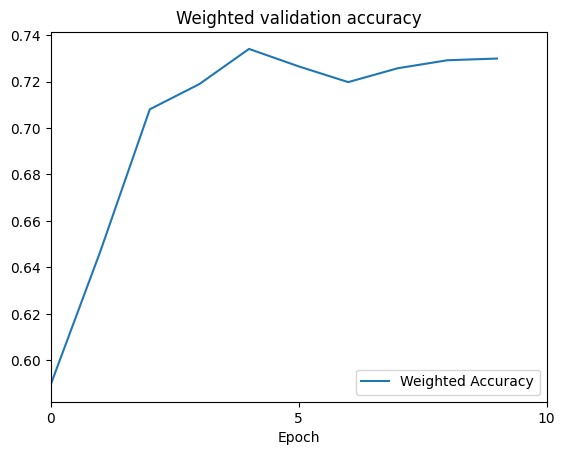

In [23]:
training_metrics = pd.DataFrame(list(study.best_trial.intermediate_values.items()), columns=['Epoch', 'Accuracy'])

ax = training_metrics.plot.line(x="Epoch", y="Accuracy")
ax.legend(labels=["Weighted Accuracy"], loc="lower right")
ax.set(title="Weighted validation accuracy")
ax.set_xlim(left=0)
ax.set_xticks(ticks=[*range(0, training_metrics.Epoch.max() + 2, 5)])

plt.show()